In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
df = pd.read_csv(
    './data/Modelar_UH2021.txt', engine='python', sep='|',
    parse_dates=[0],
    dayfirst=True,
    decimal=','
)

## Forwardfill product price and drop any missing values from the front

`ffill` in pandas rolls the values forward. This is described as the correct method by the organizer to fill the missing price values.

In [ ]:
from IPython.display import clear_output

df_fill = df.copy()

total = len(df.id.unique())

for i, pid in enumerate(df.id.unique()):
    # This product's entries
    df_prod = df[df.id == pid]
    
    # Fillforward, then back to cover the first few lines
    df_prod = df_prod.fillna(method='ffill').fillna(method='bfill')

    # Save to DF
    df_fill.loc[df_prod.index] = df_prod
    
    clear_output(wait=True)
    print("Filled %.1f%% of the Dataframe" % (i/total * 100))

df_fill.to_csv('./data/Modelar_UH2021_filled_precio.txt')

## Use this DF from here on with the filled Price

In [2]:
df = pd.read_csv(
    './data/Modelar_UH2021_filled_precio.txt', parse_dates=[1], index_col=0
)

c:\bin\python3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Feature Engineering and data cleaning

In [3]:
df['categoria_dos'] = df.categoria_dos.astype('str').str.replace('.0','')

c:\bin\python3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [4]:
df['dia_atipico_neg'] = (df.dia_atipico == -1).astype(int)
df['dia_atipico_neu'] = (df.dia_atipico == 0).astype(int)
df['dia_atipico_pos'] = (df.dia_atipico == 1).astype(int)

df['estado_no_rotura'] = (df.estado == 'No Rotura').astype(int)
df['estado_transito'] = (df.estado == 'Transito').astype(int)
df['estado_rotura'] = (df.estado == 'Rotura').astype(int)

df[:5]

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_no_rotura,estado_transito,estado_rotura
0,2015-06-01,21972,0,C,75,No Rotura,5.84,0,0,5241.0,0,0,1,0,1,0,0
1,2015-06-01,23910,5,C,1,No Rotura,6.07,0,0,5241.0,3,0,1,0,1,0,0
2,2015-06-01,24306,13,A,46,No Rotura,7.85,0,0,NaN,0,0,1,0,1,0,0
3,2015-06-01,24306,13,A,46,No Rotura,7.85,0,0,NaN,0,0,1,0,1,0,0
4,2015-06-01,27144,15,E,2,No Rotura,6.12,0,0,4064.0,0,0,1,0,1,0,0


In [5]:
df_categoria_uno_onehot = pd.get_dummies(df.categoria_uno, prefix='categoria_uno_')
df_categoria_dos_onehot = pd.get_dummies(df.categoria_dos, prefix='categoria_dos_')

df_fe = pd.concat([df, df_categoria_uno_onehot, df_categoria_dos_onehot], axis=1)
del df_fe['categoria_uno']
del df_fe['categoria_dos']
del df_fe['estado']
del df_fe['dia_atipico']

df_fe[:5]

,fecha,id,visitas,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,...,categoria_dos__86,categoria_dos__89,categoria_dos__9,categoria_dos__92,categoria_dos__93,categoria_dos__95,categoria_dos__96,categoria_dos__97,categoria_dos__98,categoria_dos__nan
0,2015-06-01,21972,0,5.84,0,5241.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2015-06-01,23910,5,6.07,0,5241.0,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2015-06-01,24306,13,7.85,0,NaN,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2015-06-01,24306,13,7.85,0,NaN,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2015-06-01,27144,15,6.12,0,4064.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Data Quality (NANs etc)

### TODO: Better `antiguedad` fill

In [6]:
df_fe_no_nans = df_fe.dropna(how='any', inplace=False)
df_fe_no_nans[:5]

,fecha,id,visitas,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,...,categoria_dos__86,categoria_dos__89,categoria_dos__9,categoria_dos__92,categoria_dos__93,categoria_dos__95,categoria_dos__96,categoria_dos__97,categoria_dos__98,categoria_dos__nan
0,2015-06-01,21972,0,5.84,0,5241.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2015-06-01,23910,5,6.07,0,5241.0,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2015-06-01,27144,15,6.12,0,4064.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,2015-06-01,27504,7,10.74,0,5261.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,2015-06-01,30014,5,6.12,0,2954.0,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Visualize time series for Sold units (Target)

Grouped by date.

<AxesSubplot:xlabel='fecha'>

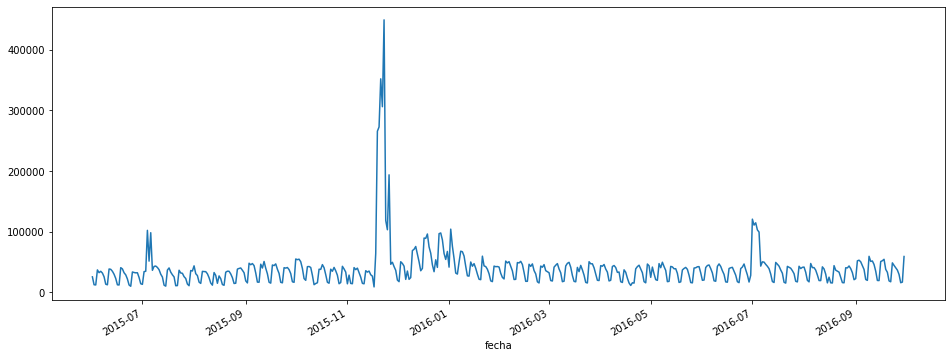

In [60]:
plt.figure(figsize=[16,6])

data = df_fe.groupby('fecha').sum().sort_values('fecha')
data.unidades_vendidas.plot()

## Distribution of the Target Variable

- Unbalanced data set (so many lines are of value 0)
- Long tail of numbers, follows zipf distribution more or less, where nth number is proportional to 1/n

<AxesSubplot:xlabel='unidades_vendidas', ylabel='Count'>

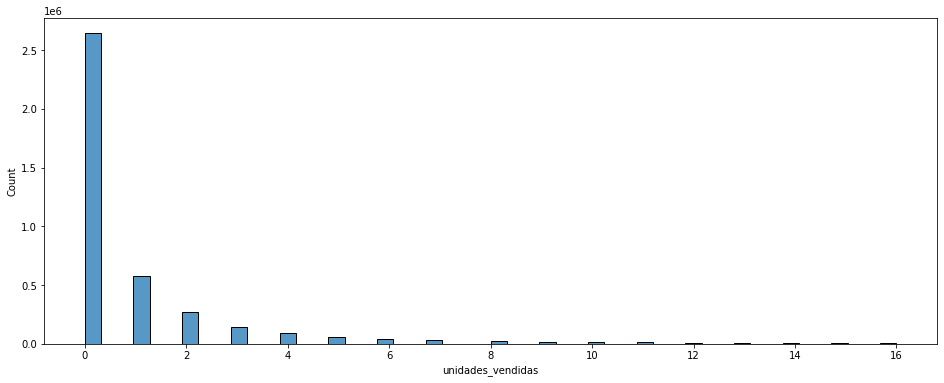

In [261]:
plt.figure(figsize=[16,6])

data = df_fe.unidades_vendidas[df_fe.unidades_vendidas < 50]

sns.histplot(data // 3, bins=50)

## Single product target variable Plot

<AxesSubplot:xlabel='fecha,id'>

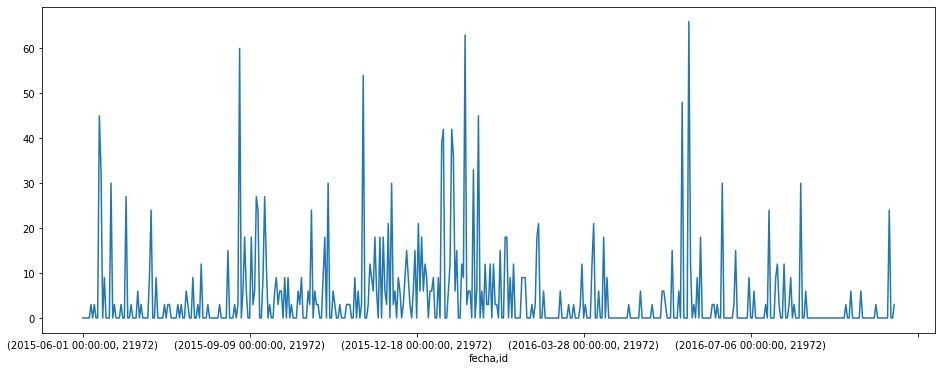

In [102]:
plt.figure(figsize=[16,6])

data = df_fe[['fecha', 'id', 'unidades_vendidas']]
data = data.groupby(['fecha','id']).sum()

pid = 21972
data.loc[(slice(None), slice(pid)), :].unidades_vendidas.plot()

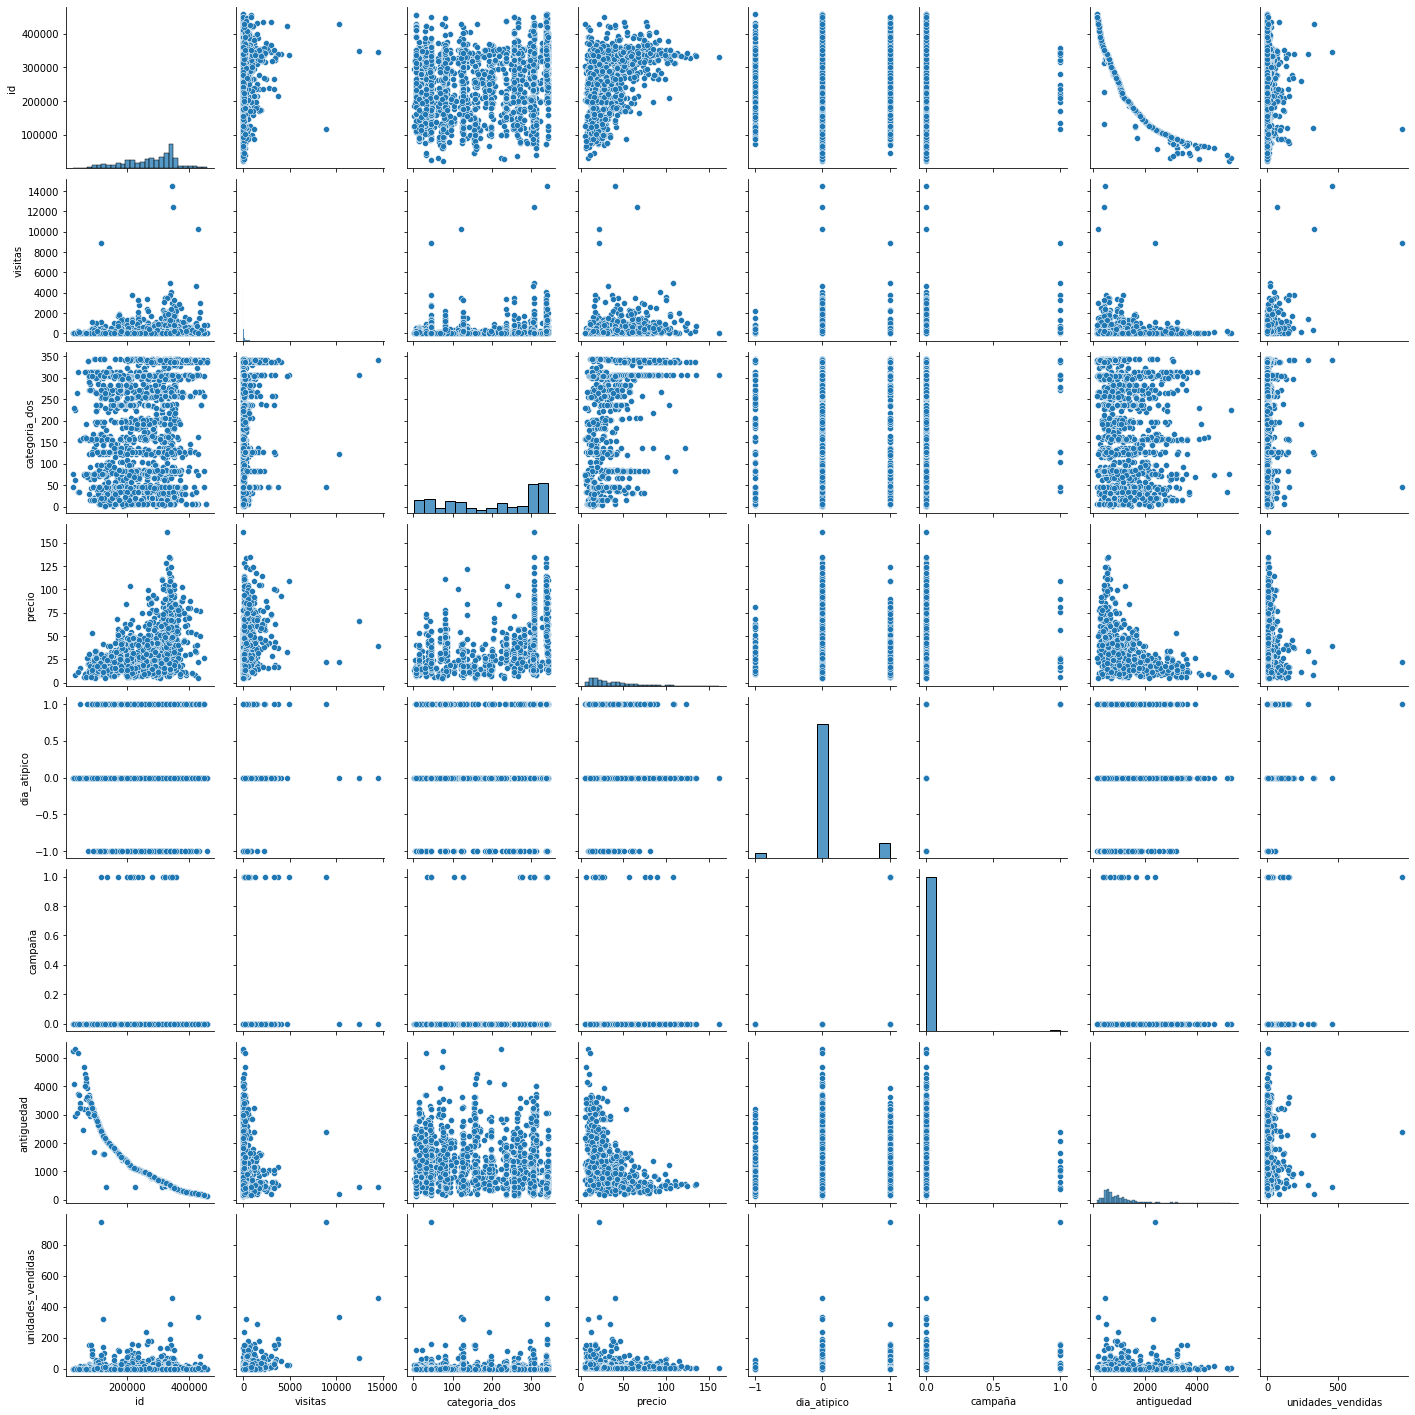

In [105]:
sns.pairplot(df[::1000])

## Naive DS : Random forest

In [7]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = df_fe_no_nans[df_fe.columns.values[2:]]
del X['unidades_vendidas']

y = df_fe_no_nans['unidades_vendidas']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

In [8]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = RandomForestRegressor()

model.fit(X_train, y_train)